<a href="https://colab.research.google.com/github/chatterjeerajdeep/machine-learning-projects/blob/main/Linear_Regression_on_insurance_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import statements



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import *
import seaborn as sns
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Import data

In [ ]:
data = pd.read_csv("/content/insurance.csv")

#### Objective

What we know from the [previous](https://github.com/chatterjeerajdeep/explore-machine-learning/blob/main/EDA_for_insurance_data.ipynb) exploratory data analysis:

1. We want to relate the **charges** incurred by beneficiaries to information like **age, bmi, smoker status, number of children, sex and region**
2. Features like **smoker status, bmi and age** were observed to affect the charges, **the most**
3. Features like **number of children, sex and region** were observed to be **not that important**, although slight variations could be seen in the effect of sex and region, majorly due to the influence of presence of smokers 
4. Beneficiaries having **no children** were found to claim **lower charges**
5. The variation in  **charges** incurred with increase in **bmi** was majorly **influenced by smoker status**
6. The variation in **charges** incurred for every **age** group was majorly **influenced by smoker status**

What do we want to achieve?
1. Build a linear regression model to fit the data and predict charges 

1. Verify if the observations and the mathematical results tally in terms of relevance of features
2. Explore different feature scaling techniques and find their effects on the model performance
3. Compare what helps us to build a better model - our intuition about the data or backward elimination of features based on feature relevance

#### Feature Engineering

In [ ]:
# features
data_X = data.drop("charges", axis = 1)
# target
data_Y = data.charges

In [ ]:
data_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 62.8+ KB


##### transform categorical features

In [ ]:
# treat categorical variables - sex, children, smoker and region with one-hot encoding
# note: we have dropped the first column to avoid the dummy variable trap
data_X = pd.get_dummies(data_X, columns=["sex", "region", "smoker", "children"], prefix=["sex_", "region_", "smoker_", "children_"], drop_first=True)

In [ ]:
data_X.head()

,age,bmi,sex__male,region__northwest,region__southeast,region__southwest,smoker__yes,children__1,children__2,children__3,children__4,children__5
0,19,27.900,0,0,0,1,1,0,0,0,0,0
1,18,33.770,1,0,1,0,0,1,0,0,0,0
2,28,33.000,1,0,1,0,0,0,0,1,0,0
3,33,22.705,1,1,0,0,0,0,0,0,0,0
4,32,28.880,1,1,0,0,0,0,0,0,0,0


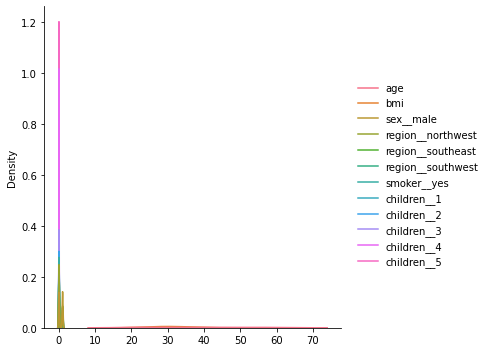

In [ ]:
# observe the distribution of features
sns.displot(data_X, kind='kde')

Obviously, each feature has it's own scale

##### feature scaling

Do we need feature scaling for linear regression?

* There are 2 ways that Linear Regression is implemented - Matrix method and Gradient Descent method.

* Scaling features can help to converge faster in case of gradient descent. In case of matrix method, it does not make much of a difference as the coefficients compensate for the scale.

* However, scaling can improve the interpretability of the features, and hence has no harm in implementing.







We will use the information from the [previous](https://github.com/chatterjeerajdeep/explore-machine-learning/blob/main/EDA_for_insurance_data.ipynb) analysis, about presence of outliers and skewness of data here

In [ ]:
# trying min_max_scaler - transforms the range of the data between 0 and 1, this does not affect the spread of the data
data_X_min_max = MinMaxScaler().fit_transform(data_X)

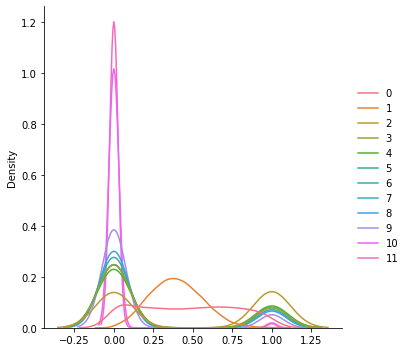

In [ ]:
sns.displot(data_X_min_max, kind='kde')

In [ ]:
# trying standard scaler - transforms data to have mean 0 std dev 1
data_X_std = StandardScaler().fit_transform(data_X)

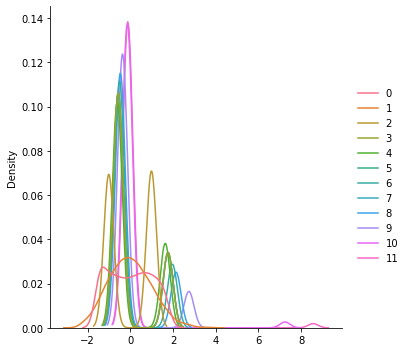

In [ ]:
sns.displot(data_X_std, kind='kde')

In [ ]:
# trying robust scaler - unlike the previous two method of scaling, this method is not affected 
# by outliers
# feature like bmi has some outliers
data_X_robust = RobustScaler().fit_transform(data_X)

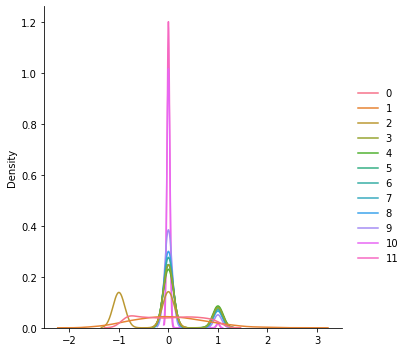

In [ ]:
sns.displot(data_X_robust, kind='kde')

1.5158796580240388


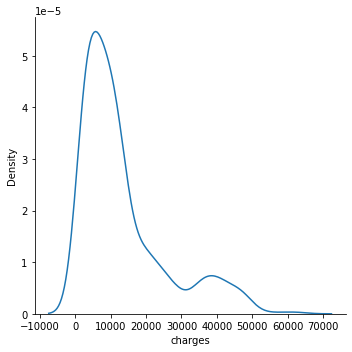

In [ ]:
# our target variable is positively skewed
sns.displot(data_Y, kind='kde')
print(data_Y.skew())

-0.08981728740026819


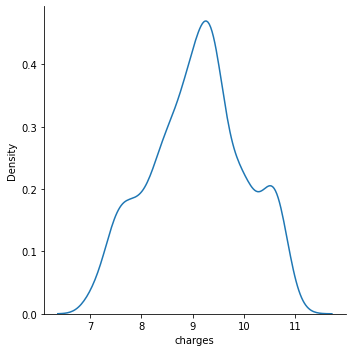

In [ ]:
# linear regression works best with normal distribution of data
# applying logarithm on the target variable to correct skewness
logged_y = np.log1p(data_Y)
sns.displot(logged_y, kind='kde')
print(logged_y.skew())

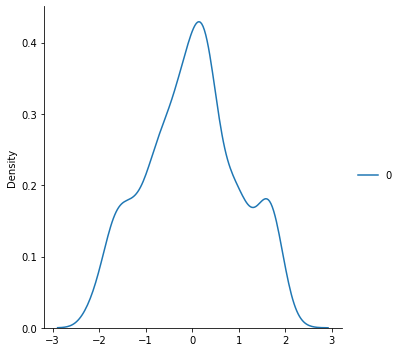

In [ ]:
# applying box-cox transformation
box_cox_y = power_transform(np.array(data_Y).reshape(1338,1), method='box-cox')
sns.displot(box_cox_y, kind='kde')

#### Apply Linear Regression

##### No transformations applied

In [ ]:
# model 1
# account for intercept
data_X_arr = sm.add_constant(data_X)

model = sm.OLS(data_Y, data_X_arr)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     334.7
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:17:05   Log-Likelihood:                -13545.
No. Observations:                1338   AIC:                         2.712e+04
Df Residuals:                    1325   BIC:                         2.718e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.193e+04    993.65

##### Observations
1. The coefficients obtained are of varying range
2. The adjusted r-squared is 0.75
3. sex, region and children one-hot encoded features have a high p-value, meaning that they are not statistically significant. This verifies our observations
4. age, bmi and smoker have a very low p-value almost equal to zero. This verifies our observations

##### Apply Backward Elimination based on p-value

In [ ]:
# model 2: removing the feature with highest p-value - sex__male
data_X_mod1 = data_X.drop(["sex__male"], axis = 1)

# account for intercept
data_X_arr = sm.add_constant(data_X_mod1)

model_mod1 = sm.OLS(data_Y, data_X_arr)
results = model_mod1.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     365.3
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:17:48   Log-Likelihood:                -13545.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1326   BIC:                         2.718e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.198e+04    984.79

In [ ]:
# model 3: removing the feature with highest p-value - children__5
data_X_mod2 = data_X_mod1.drop(["children__5"], axis = 1)

# account for intercept
data_X_arr = sm.add_constant(data_X_mod2)

model_mod2 = sm.OLS(data_Y, data_X_arr)
results = model_mod2.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     401.9
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:19:09   Log-Likelihood:                -13545.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1327   BIC:                         2.717e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.192e+04    981.93

In [ ]:
# model 4: removing the feature with highest p-value - region__northwest
data_X_mod3 = data_X_mod2.drop(["region__northwest"], axis = 1)

# account for intercept
data_X_arr = sm.add_constant(data_X_mod3)

model_mod3 = sm.OLS(data_Y, data_X_arr)
results = model_mod3.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     446.7
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:20:06   Log-Likelihood:                -13546.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1328   BIC:                         2.716e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.211e+04    953.15

In [ ]:
# model 5: removing the feature with highest p-value - children__1
data_X_mod4 = data_X_mod3.drop(["children__1"], axis = 1)

# account for intercept
data_X_arr = sm.add_constant(data_X_mod4)

model_mod4 = sm.OLS(data_Y, data_X_arr)
results = model_mod4.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     502.5
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:20:46   Log-Likelihood:                -13546.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1329   BIC:                         2.716e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -1.2e+04    943.59

In [ ]:
# model 6: removing the feature with highest p-value - children__3
data_X_mod5 = data_X_mod4.drop(["children__3"], axis = 1)

# account for intercept
data_X_arr = sm.add_constant(data_X_mod5)

model_mod5 = sm.OLS(data_Y, data_X_arr)
results = model_mod5.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     573.4
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:21:30   Log-Likelihood:                -13547.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1330   BIC:                         2.715e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.194e+04    943.21

In [ ]:
# model 7: removing the feature with highest p-value - region__southwest
data_X_mod6 = data_X_mod5.drop(["region__southwest"], axis = 1)

# account for intercept
data_X_arr = sm.add_constant(data_X_mod6)

model_mod6 = sm.OLS(data_Y, data_X_arr)
results = model_mod6.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     667.3
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:22:29   Log-Likelihood:                -13549.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1331   BIC:                         2.715e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -1.205e+04    942.12

In [ ]:
# model 8: removing the feature with highest p-value - region__southeast
data_X_mod7 = data_X_mod6.drop(["region__southeast"], axis = 1)

# account for intercept
data_X_arr = sm.add_constant(data_X_mod7)

model_mod7 = sm.OLS(data_Y, data_X_arr)
results = model_mod7.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     799.5
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:23:45   Log-Likelihood:                -13550.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1332   BIC:                         2.714e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.187e+04    935.091    -12.696      

##### Observation
1. We end up with age, bmi, smoker and children as the significant features
2. The adjusted r-squared value for the final model is 74.9 which is very close to what we observed at the beginning

##### Will transformation of features help in improving the adjusted r-squared metrics?

In [ ]:
# try min_max_scaler
data_X_min_max = MinMaxScaler().fit_transform(data_X_mod7)
# try standard scaler
data_X_std = StandardScaler().fit_transform(data_X_mod7)
# try robust scaler
data_X_robust = RobustScaler().fit_transform(data_X_mod7)

###### min_max scaler

In [ ]:
# with min_max_scaler
# account for intercept
data_X_arr = sm.add_constant(data_X_min_max)

model_min_max = sm.OLS(data_Y, data_X_arr)
results = model_min_max.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     799.5
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:29:19   Log-Likelihood:                -13550.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1332   BIC:                         2.714e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2100.8629    493.101     -4.261      0.0

###### standard scaler

In [ ]:
# account for intercept
data_X_arr = sm.add_constant(data_X_std)

model_std = sm.OLS(data_Y, data_X_arr)
results = model_std.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     799.5
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:31:27   Log-Likelihood:                -13550.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1332   BIC:                         2.714e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.327e+04    165.822     80.028      0.0

###### robust scaler

In [ ]:
# account for intercept
data_X_arr = sm.add_constant(data_X_robust)

model_robust = sm.OLS(data_Y, data_X_arr)
results = model_robust.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     799.5
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:31:51   Log-Likelihood:                -13550.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1332   BIC:                         2.714e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7962.3883    202.912     39.241      0.0

##### Observation

None of the scalers helped in improving the metrics. However, the coefficients got converted into a comparable range

###### applying log on the target variable


In [ ]:
# account for intercept
data_X_arr = sm.add_constant(data_X_robust)

model_robust_target_transformed = sm.OLS(logged_y, data_X_arr)
results = model_robust_target_transformed.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     818.8
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:34:33   Log-Likelihood:                -845.97
No. Observations:                1338   AIC:                             1704.
Df Residuals:                    1332   BIC:                             1735.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.7298      0.015    571.792      0.0

###### applying box-cox on the target variable

In [ ]:
# account for intercept
data_X_arr = sm.add_constant(data_X_robust)

model_robust_target_transformed = sm.OLS(box_cox_y, data_X_arr)
results = model_robust_target_transformed.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     837.0
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:35:53   Log-Likelihood:                -947.79
No. Observations:                1338   AIC:                             1908.
Df Residuals:                    1332   BIC:                             1939.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4054      0.016    -24.608      0.0

##### Observation

Both log transformation and box-cox transformation of the target variable helped in improving the adjusted r-quared metrics. But clearly, box-cox transformation helped in improving the metrics more than log transformation

#### Can intuition beat the scores?

Based on our observations listed in the beginning of this notebook, we can remove the features sex and region altogether. Clearly, the effect of bmi and age is driven majorly by the smoker status. So, it can be interesting to add interaction terms for bmi and smoker, and age and smoker.

Will this knowledge about the data help us in modeling the relation any better?

In [ ]:
data_X = data.drop(["charges", "sex"], axis = 1)
data_X = pd.get_dummies(data_X, columns=["region", "children", "smoker"], prefix=["region_", "children_", "smoker_"], drop_first=True)
data_X["bmi_smoker_interaction"] = data_X["bmi"] * data_X["smoker__yes"]
data_X["age_smoker_interaction"] = data_X["age"] * data_X["smoker__yes"]
print(data_X.columns)
data_X = StandardScaler().fit_transform(data_X)
# account for intercept
data_X_arr = sm.add_constant(data_X) 

model_new1 = sm.OLS(box_cox_y, data_X_arr)
results = model_new1.fit()
print(results.summary())

Index(['age', 'bmi', 'region__northwest', 'region__southeast',
       'region__southwest', 'children__1', 'children__2', 'children__3',
       'children__4', 'children__5', 'smoker__yes', 'bmi_smoker_interaction',
       'age_smoker_interaction'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.826
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     485.1
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:45:17   Log-Likelihood:                -726.79
No. Observations:                1338   AIC:                             1482.
Df Residuals:                    1324   BIC:                             1554.
Df Model:                          13                                         
Covariance Type:   

In [ ]:
data_X = data.drop(["charges", "sex", "region"], axis = 1)
data_X = pd.get_dummies(data_X, columns=["children", "smoker"], prefix=["children_", "smoker_"], drop_first=True)
data_X["bmi_smoker_interaction"] = data_X["bmi"] * data_X["smoker__yes"]
data_X["age_smoker_interaction"] = data_X["age"] * data_X["smoker__yes"]
data_X = data_X.drop("bmi", axis = 1)
print(data_X.columns)
data_X = StandardScaler().fit_transform(data_X)
# account for intercept
data_X_arr = sm.add_constant(data_X) 

model_new1 = sm.OLS(logged_y, data_X_arr)
results = model_new1.fit()
print(results.summary())

Index(['age', 'children__1', 'children__2', 'children__3', 'children__4',
       'children__5', 'smoker__yes', 'bmi_smoker_interaction',
       'age_smoker_interaction'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     674.7
Date:                Mon, 31 May 2021   Prob (F-statistic):               0.00
Time:                        17:46:48   Log-Likelihood:                -636.37
No. Observations:                1338   AIC:                             1293.
Df Residuals:                    1328   BIC:                             1345.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 

#### Observation

1. Our intuition clearly worked much better than the methodical approach. We achieved an adjusted r-squared value of 0.819
2. Adding interaction terms helped in modeling better as it encoded the practical relations among the features
3. The bmi data had no more significance once the interaction term with smoker was captured
4. All the coefficients are positive signifying a positive impact on the target variable. However, the age-smoker interaction coefficient is negative, probably implying that the effect of smoker status decreases for younger ages